In [1]:
!pip install  torch-geometric networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.5 MB/s eta 0:00:00


Processing...
Done!


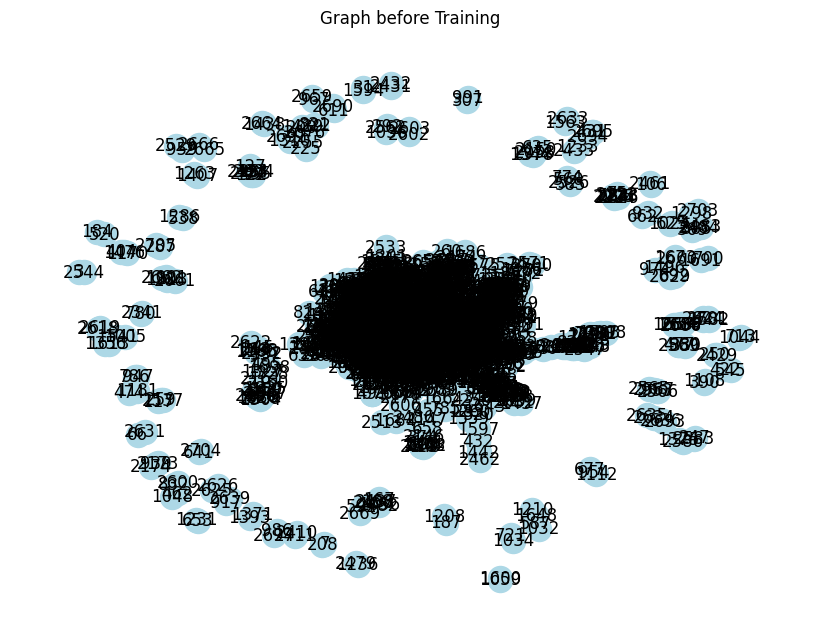

Epoch 0, Loss: 1.9591
Epoch 20, Loss: 0.3103
Epoch 40, Loss: 0.0625
Epoch 60, Loss: 0.0523
Epoch 80, Loss: 0.0185
Epoch 100, Loss: 0.0132
Epoch 120, Loss: 0.0232
Epoch 140, Loss: 0.0176
Epoch 160, Loss: 0.0141
Epoch 180, Loss: 0.0047


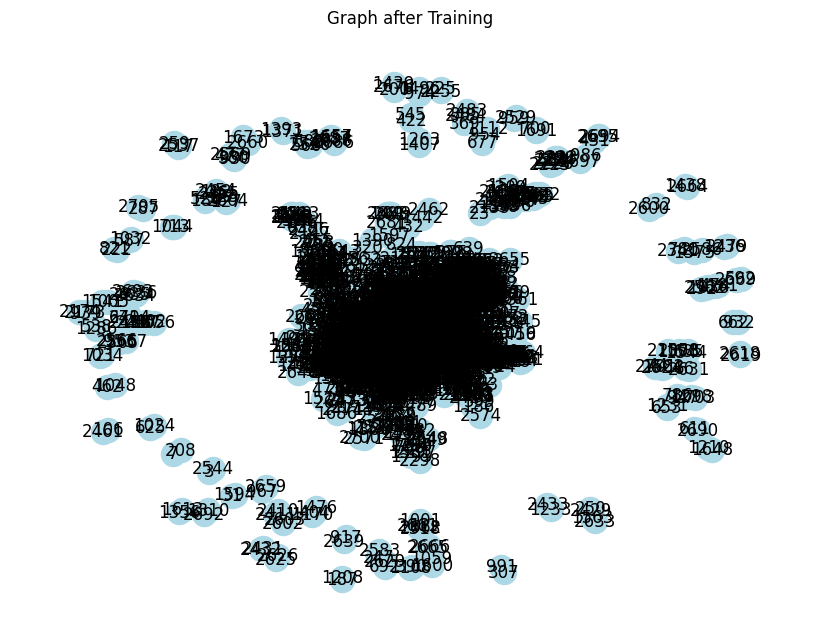

Predictions for test nodes: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 4 1 1 1 1 1 1 6 4 4 4 4 4 1 2 0 2 1 6 2 1 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 5 5 5 5 5 5 2 2 2 2 2 6 6 2 0 0 0 0 5 0 0 0 3 0 0 6 0 6 3 3 3 3
 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 5 5 5 5 5 5 5 2 2 2 4 4 4 4
 3 3 2 5 5 5 5 6 5 5 5 5 4 4 4 0 0 1 0 0 0 6 6 6 6 6 6 6 0 0 0 0 0 6 0 3 4
 0 3 3 3 3 3 3 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 4 4 4
 4 4 4 4 4 6 0 0 6 6 2 5 5 5 0 5 4 4 4 2 3 3 2 3 2 2 3 3 2 3 3 1 2 2 4 4 4
 3 3 3 2 3 2 6 3 0 0 0 0 6 5 5 5 4 0 4 6 5 2 1 3 5 5 6 6 4 4 4 4 4 3 4 4 4
 4 4 4 4 1 1 1 1 0 6 0 0 0 0 0 0 0 2 0 5 5 5 3 3 3 3 3 0 0 0 0 0 0 0 3 3 3
 1 1 1 1 1 2 1 1 1 1 1 1 1 3 1 1 1 1 1 0 0 0 6 6 0 0 5 0 1 1 0 6 6 6 6 2 3
 2 0 3 2 4 4 4 4 4 4 4 4 4 4 4 4 0 6 0 6 6 0 0 3 3 3 3 3 1 1 1 3 3 3 3 2 6
 0 5 6 0 5 6 6 6 6 6 3 3 6 6 6 2 2 1 0 0 0 2 2 3 3 0 5 0 0 0 0 0 5 5 0 4

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import networkx as nx

# Загрузка датасета Cora
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# Определение модели GCN
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Инициализация модели, оптимизатора и устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(dataset.num_node_features, 16, dataset.num_classes).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Обучение модели
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Визуализация графа
def visualize_graph(data, title):
    G = nx.from_edgelist(data.edge_index.t().cpu().numpy())
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color='lightblue', with_labels=True)
    plt.title(title)
    plt.show()

# Визуализация графа до обучения
visualize_graph(data, "Graph before Training")

# Обучение на протяжении нескольких эпох
for epoch in range(200):
    loss = train()
    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

# Визуализация графа после обучения (для простоты мы не изменяем граф)
visualize_graph(data, "Graph after Training")

# Прогнозирование связей (например, для тестовых узлов)
model.eval()
with torch.no_grad():
    pred = model(data.x, data.edge_index).argmax(dim=1)

# Вывод предсказаний для тестовых узлов
print("Predictions for test nodes:", pred[data.test_mask].cpu().numpy())
